In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

In [ ]:
adata_path = "lung_atlas.h5ad"

adata = sc.read_h5ad(
    adata_path,
    backup_url="https://figshare.com/ndownloader/files/24539942",
)

In [11]:
adata.obs
#np.unique(adata.obs.dataset)

,dataset,location,nGene,nUMI,patientGroup,percent.mito,protocol,sanger_type,size_factors,sampling_method,batch,cell_type,donor
index,,,,,,,,,,,,,
GAGGGGCCAGCC,Dropseq_transplant,Dropseq_lower,249,355,nan,0.019718,drop-seq,drop-seq,0.381231,Transplant,B1,Type 2,B1
ACATAGATAGGC,Dropseq_transplant,Dropseq_lower,582,987,nan,0.044580,drop-seq,drop-seq,1.081643,Transplant,B1,Type 2,B1
ATCGACGCGGCA,Dropseq_transplant,Dropseq_lower,292,490,nan,0.026531,drop-seq,drop-seq,0.497352,Transplant,B1,Type 2,B1
CCAGCTTAGGTT,Dropseq_transplant,Dropseq_lower,1057,1806,nan,0.035437,drop-seq,drop-seq,2.172617,Transplant,B1,Type 2,B1
TCATAGAGTCCT,Dropseq_transplant,Dropseq_lower,716,1378,nan,0.020319,drop-seq,drop-seq,1.197578,Transplant,B1,Type 2,B1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
LungTranscriptome7239219_LungTranscriptome7239219GGGCATCCACCAACCG,10x_Transplant,Transplant,1178,3245,Parenchyma,0.011896,10x v2,other,0.775650,Transplant,5,Mast cell,5
LungTranscriptome7239219_LungTranscriptome7239219TGCTGCTAGCAATCTC,10x_Transplant,Transplant,1919,5984,Parenchyma,0.018747,10x v2,other,0.982236,Transplant,5,Mast cell,5
LungTranscriptome7239213_GACTGCGTCCTGCCAT,10x_Transplant,Transplant,4411,25233,Parenchyma,0.010489,10x v2,other,1.235763,Transplant,3,Mast cell,3


# Try integration two datasets

## Load the two timepoints and preprocessing 

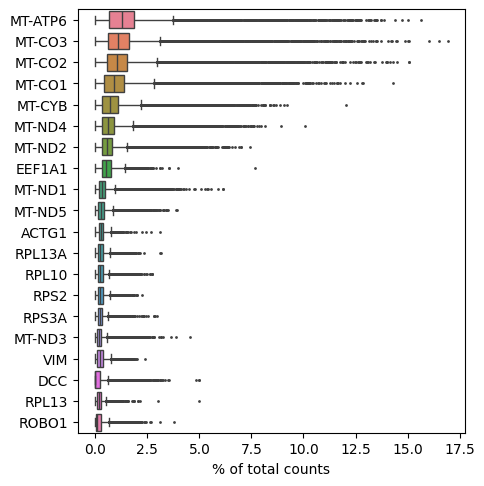

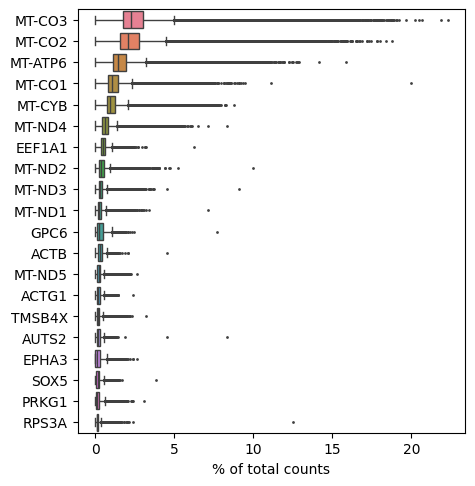

In [13]:
D20_1 = sc.read_10x_mtx("../data/initial_10x_outputs/filtered_feature_bc_matrix-D20_1")
D12_1 = sc.read_10x_mtx("../data/initial_10x_outputs/filtered_feature_bc_matrix-D12_1")

sc.pl.highest_expr_genes(D20_1, n_top=20)
sc.pl.highest_expr_genes(D12_1, n_top=20)

#Basic filtering genes not expressed + cell with too few genes
sc.pp.filter_cells(D20_1, min_genes=200)
sc.pp.filter_genes(D20_1, min_cells=3)

sc.pp.filter_cells(D12_1, min_genes=200)
sc.pp.filter_genes(D12_1, min_cells=3)

#Define the mitochondrial genes + compute QC metrics
D20_1.var["mt"] = D20_1.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    D20_1, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

D12_1.var["mt"] = D12_1.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    D12_1, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

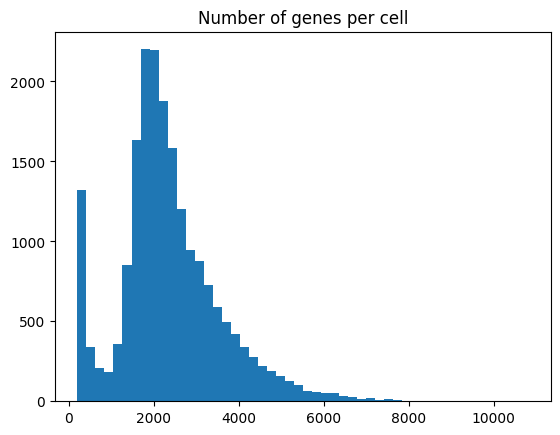

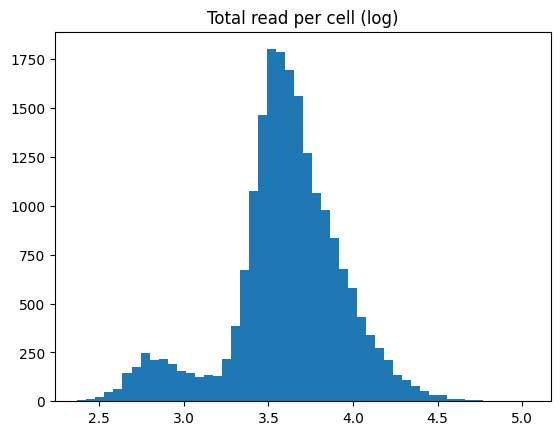

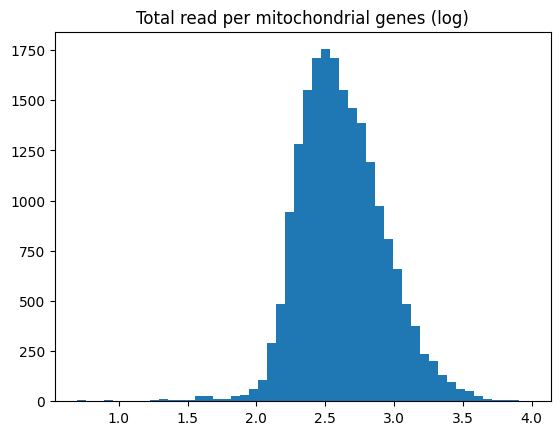

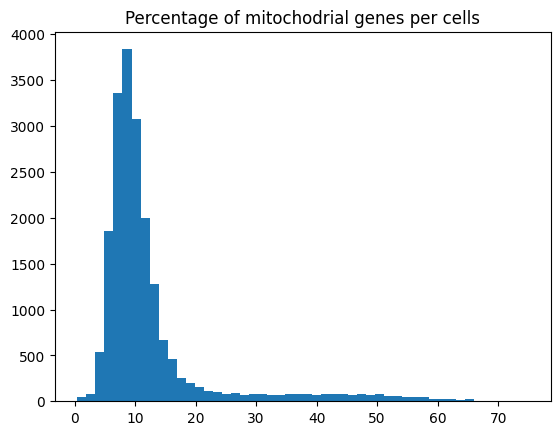

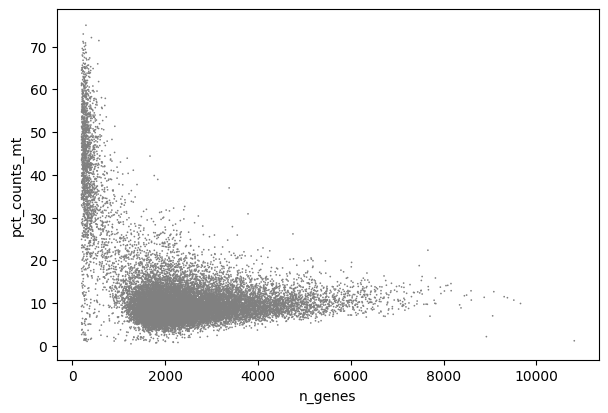

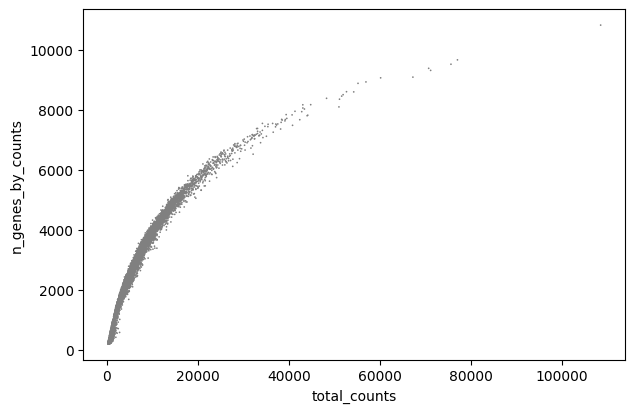

In [4]:
#Visualize distribution of cell metrics to define filtering thresholds
plt.hist(D12_1.obs.n_genes, bins=50)
plt.title("Number of genes per cell")
plt.show()

plt.hist(np.log10(D12_1.obs.total_counts), bins=50)
plt.title("Total read per cell (log)")
plt.show()

plt.hist(np.log10(D12_1.obs.total_counts_mt), bins=50)
plt.title("Total read per mitochondrial genes (log)")
plt.show()

plt.hist(D12_1.obs.pct_counts_mt, bins=50)
plt.title("Percentage of mitochodrial genes per cells")
plt.show()

sc.pl.scatter(D12_1, x="n_genes", y="pct_counts_mt")
sc.pl.scatter(D12_1, x="total_counts", y="n_genes_by_counts")

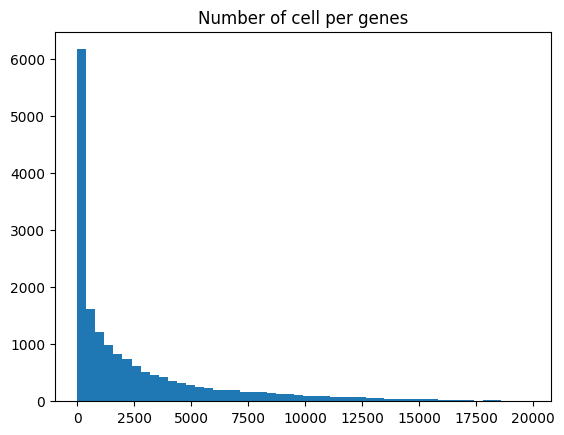

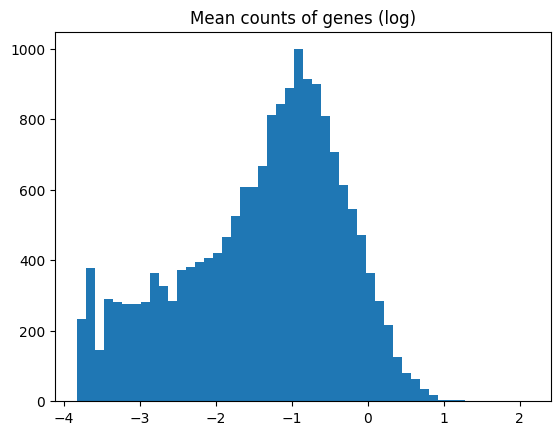

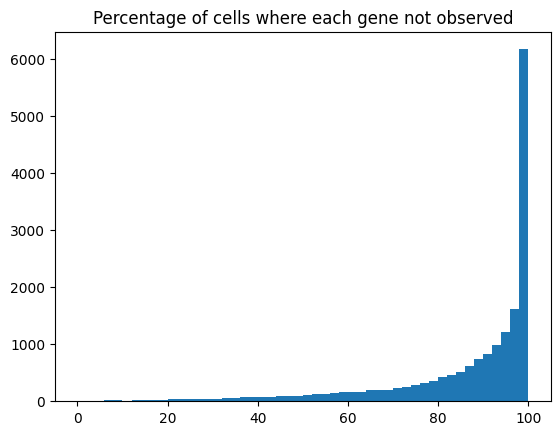

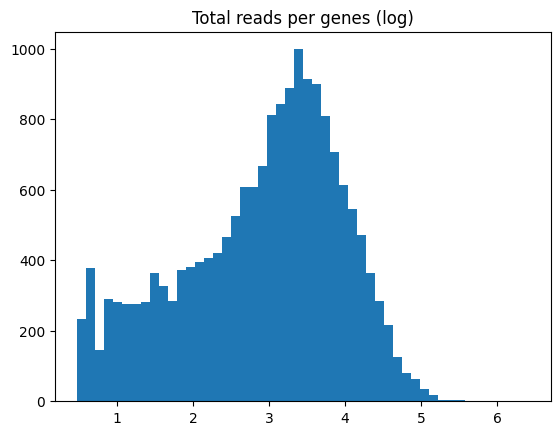

In [14]:
#Visualize distribution of genes metrics to define filtering thresholds
plt.hist(D12_1.var.n_cells, bins=50)
plt.title("Number of cell per genes")
plt.show()

plt.hist(np.log10(D12_1.var.mean_counts), bins=50)
plt.title("Mean counts of genes (log)")
plt.show()

plt.hist(D12_1.var.pct_dropout_by_counts, bins=50)
plt.title("Percentage of cells where each gene not observed")
plt.show()

plt.hist(np.log10(D12_1.var.total_counts), bins=50)
plt.title("Total reads per genes (log)")
plt.show()

In [15]:
#Filter cells 

#Remove all cell with % mt > 20% + extreme total counts
D20_1 = D20_1[D20_1.obs.pct_counts_mt < 20]
D20_1 = D20_1[D20_1.obs.total_counts < 100000]

D12_1 = D12_1[D12_1.obs.pct_counts_mt < 20]
D12_1 = D12_1[D12_1.obs.total_counts < 100000]

In [ ]:
#scvi Use the raw counts, not normalized
""" # Normalize + log transform
sc.pp.normalize_per_cell(D20_1)
sc.pp.log1p(D20_1)

sc.pp.normalize_per_cell(D12_1)
sc.pp.log1p(D12_1) """


In [16]:
#Merge into a single object
print(D12_1)
print(D20_1)

adata = D12_1.concatenate(D20_1)

View of AnnData object with n_obs × n_vars = 17667 × 17690
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
View of AnnData object with n_obs × n_vars = 10626 × 17919
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'


/var/folders/nx/fx90wvl146lcdkglfty5_wr4qnvn43/T/ipykernel_60809/1853596318.py:5: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = D12_1.concatenate(D20_1)


# Should I merge both objects into one before doing this step = add batch key???

Look at the tutorial -> donwload data and figure it out

In [17]:
#Feature selection: highly variable genes, take to 1000 to 10000 HVGs
sc.pp.highly_variable_genes(D20_1, 
                            n_top_genes=5000,
                            flavor='seurat_v3'
)

sc.pp.highly_variable_genes(D12_1, 
                            n_top_genes=5000,
                            flavor='seurat_v3'
)


/Users/adorman/.local/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:151: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": "seurat_v3"}
